In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.decomposition import PCA, KernelPCA

In [60]:
from mpl_toolkits.mplot3d import proj3d
def plot3D(px,py,pz,clist,emphPoints = [],cmap='plasma',title='',shadow=False,useCMAP = True,xLabel='',yLabel='',zLabel='',savefig='',saveN = 1, setRange = 0):
    
    elev = 30
    azim = 60

    viewVect = [np.cos(np.pi*180/elev)*np.sin(np.pi*180/azim),np.cos(np.pi*180/elev)*np.cos(np.pi*180/azim),np.cos(np.pi*180/elev)]
    
    thetalist = np.linspace(0,2*np.pi,saveN + 1)
    thetalist = thetalist[:-1]
    
    projMat = np.array([px,py])
    
    for idx in range(saveN):
        theta = thetalist[idx]
        rotMat = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        
        rotx,roty = np.dot(rotMat,projMat)
        rotz = pz
        clistRot = clist
        
        p = np.array([rotx,roty,rotz])
        dots = np.array(np.dot(viewVect,p))
        sort = dots.argsort()

        fig, ax = plt.subplots(figsize = (10,10))
        
        ax.set_alpha(0)
        ax.axis('off')
        
        ax = fig.gca(projection='3d')
        
        ax.patch.set_alpha(0)

        Xdist = px.max() - px.min()
        Xcntr = (px.max() + px.min())/2.0
        Ydist = py.max() - py.min()
        Ycntr = (py.max() + py.min())/2.0
        Zdist = pz.max() - pz.min()
        Zcntr = (pz.max() + pz.min())/2.0

        if setRange == 0:
            dist = 0.55*max(Xdist,Ydist,Zdist)
        else:
            dist = 0.55*setRange

        for p in emphPoints:
            ax.scatter([rotx[p]],[roty[p]],[rotz[p]],c='C1',s=200)
            if shadow:
                ax.scatter([rotx[p]],[roty[p]],[Zcntr - dist],c='black',alpha=0.5)
                ax.scatter([rotx[p]],[Ycntr + dist],[rotz[p]],c='black',alpha=0.5)
                ax.scatter([Xcntr - dist],[roty[p]],[rotz[p]],c='black',alpha=0.5)
        
        rotx = rotx[sort]
        roty = roty[sort]
        rotz = rotz[sort]
        clistRot = np.array(clistRot)[sort]
        
        if useCMAP:
            ax.scatter(rotx,roty,rotz,c=clistRot,edgecolor='black',linewidth=0.2,cmap = cmap)
        else:
            ax.scatter(rotx,roty,rotz,c=clistRot,edgecolor='black',linewidth=0.2)


        ax.set_xlim([Xcntr - dist, Xcntr + dist])
        ax.set_ylim([Ycntr - dist, Ycntr + dist])
        ax.set_zlim([Zcntr - dist, Zcntr + dist])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        #ax.set_axis_off()
        #plt.show()

        if shadow:
            #fig = plt.figure(figsize = (10,10))
            #ax = fig.gca(projection='3d')
            #ax.view_init(30,-60)

            ax.scatter(rotx,roty,[Zcntr - dist for p in rotz],c='black',alpha=0.01)
            ax.scatter(rotx,[Ycntr + dist for p in roty],rotz,c='black',alpha=0.01)
            ax.scatter([Xcntr - dist for p in rotx],roty,rotz,c='black',alpha=0.01)

            ax.set_xlim([Xcntr - dist, Xcntr + dist])
            ax.set_ylim([Ycntr - dist, Ycntr + dist])
            ax.set_zlim([Zcntr - dist, Zcntr + dist])

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

            #ax.set_axis_off()
        ax.set_xlabel(xLabel,fontsize=16)
        ax.set_ylabel(yLabel,fontsize=16)
        ax.set_zlabel(zLabel,fontsize=16)
        
        if title == '':
            pass
        else:
            plt.title(title,fontsize=30)

        if savefig == '':
            plt.show()
        else:
            plt.savefig(savefig+str(idx)+'.png')
            plt.close()

## Generate some test data

We will generate some mean-centered random linear data

In [61]:
raw_data_x = np.random.uniform(0,10, size=(100,))
raw_data_y = 2*raw_data_x+np.random.normal(0,2,len(raw_data_x))
raw_data_z = np.square(raw_data_x+0.2*np.random.normal(0,2,len(raw_data_x)))

X = np.array(list(zip(raw_data_x,raw_data_y, raw_data_z)))

We'll also need the mean-centered version of our data. For comparison with the InPCA paper later, we'll perform this shift using their matrix formulation $M = PX$

In [62]:
P = np.eye(X.shape[0]) - np.full( (X.shape[0], X.shape[0]), 1/X.shape[0])
M = np.dot(P, X)

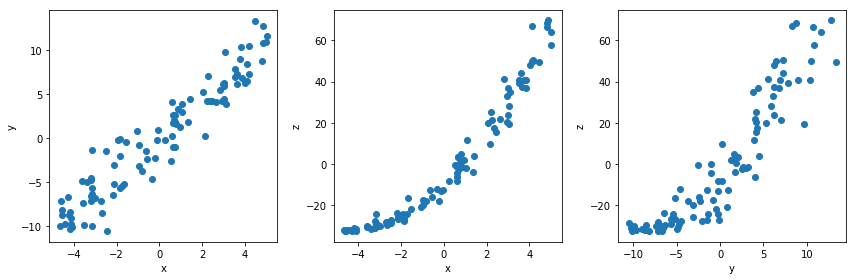

In [63]:
fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(12,4))
ax[0].scatter(M[:,0], M[:,1])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

ax[1].scatter(M[:,0], M[:,2])
ax[1].set_xlabel('x')
ax[1].set_ylabel('z')

ax[2].scatter(M[:,1], M[:,2])
ax[2].set_xlabel('y')
ax[2].set_ylabel('z')

plt.tight_layout()
plt.show()

C:\Users\Duncan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


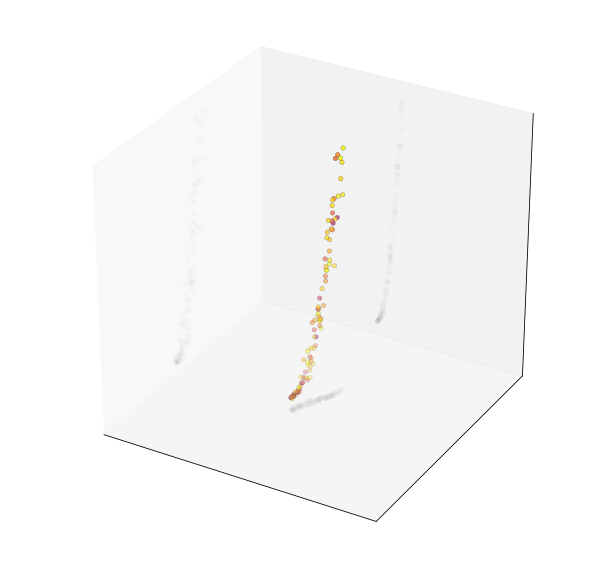

In [64]:
clist = [np.log10(param+1) for param in range(len(M))]
plot3D(M[:,0],M[:,1],M[:,2],clist,shadow=True)   

## Regular PCA

For comparison, we will first compute the PCA projections of this data

In [65]:
Cov = np.dot(np.transpose(M),M)
Eigvals, W = np.linalg.eig(Cov)

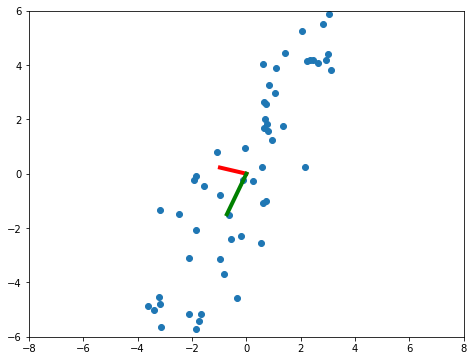

In [66]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
plt.scatter(M[:,0], M[:,1])
plt.plot([0, W[0][1]],[0, W[1][1]],'r',linewidth=4)
plt.plot([0, W[0][0]*8],[0, W[1][0]*8],'g',linewidth=4)
plt.ylim((-6,6))
plt.xlim((-8,8))
ax.set_aspect('equal') # this ensures that orthogonal vectors appear at right angles in the plot

The vectors are not quite orthogonal in this 2D projection because the nonlinearity of the data prevents the PCA projections from fully capturing the data in just two dimensions.

C:\Users\Duncan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


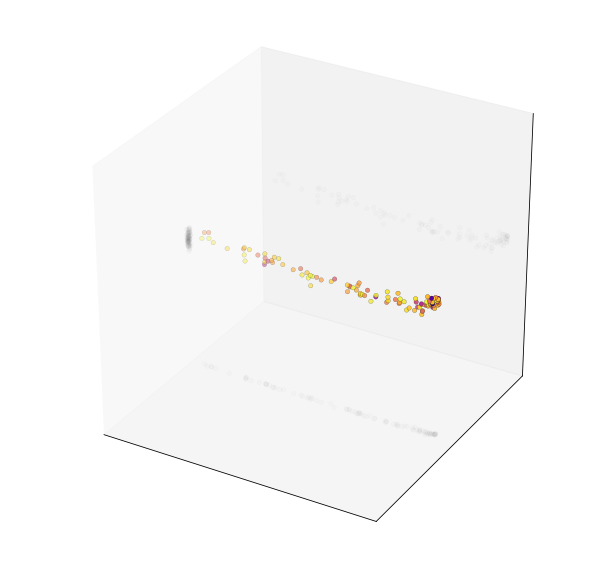

In [67]:
PCA_proj = np.dot(M,W)
plot3D(PCA_proj[:,0],PCA_proj[:,1],PCA_proj[:,2],clist,shadow=True)

## Kernel PCA
Now let's take a look at kernel PCA. This is a fairly straightforward generalization of PCA, wherein we apply some nonlinear function to produce a new data space $x_i \rightarrow \phi(x_i)$ and then perform PCA on the new dataset $\Phi = \phi(X)$. This can allow PCA to find features which are nonlinear in the original data.

As a simple example, we will use the function 
$\phi(x_i) = (x_{i}^{0}, x_{i}^{1}, \sqrt{x_{i}^{2}})$
where $x_{i}^{j}$ is the $j$-th component of $x_i$. This will, of course, make our data completely linear in its first component and should therefore yield excellent results for dimensionality reduction.

In [68]:
Phi = np.array([X[:,0],X[:,0],np.sqrt(X[:,2])]).T
Phi_M = np.dot(P, Phi)

Cov_Phi = np.dot(np.transpose(Phi_M),Phi_M)
Eigvals_Phi, W_Phi = np.linalg.eig(Cov_Phi)

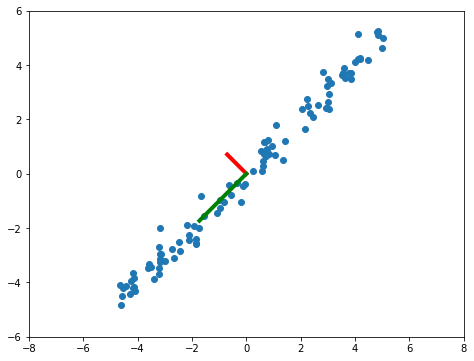

In [69]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
plt.scatter(Phi_M[:,0], Phi_M[:,2])
plt.plot([0, W_Phi[0][1]],[0, W_Phi[1][1]],'r',linewidth=4)
plt.plot([0, W_Phi[0][0]*3],[0, W_Phi[1][0]*3],'g',linewidth=4)
plt.ylim((-6,6))
plt.xlim((-8,8))
ax.set_aspect('equal') # this ensures that orthogonal vectors appear at right angles in the plot

In [70]:
W_Phi

array([[-5.75911776e-01, -7.07106781e-01, -4.10275062e-01],
       [-5.75911776e-01,  7.07106781e-01, -4.10275062e-01],
       [-5.80216557e-01, -4.68833216e-15,  8.14462244e-01]])

C:\Users\Duncan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


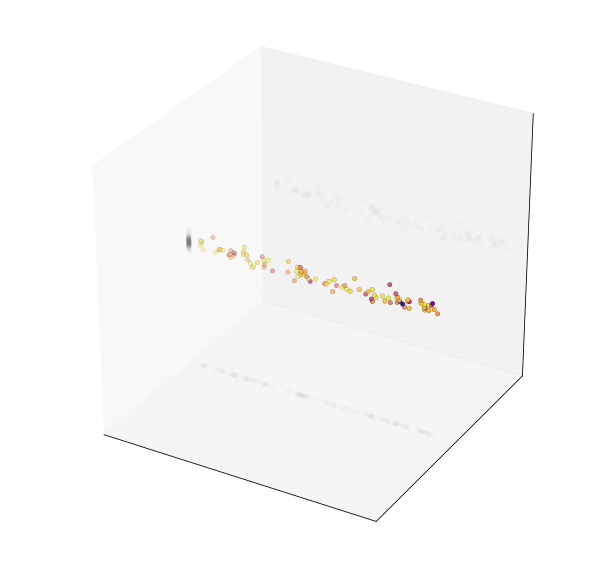

In [71]:
KPCA_proj = np.dot(Phi_M,W_Phi)
plot3D(KPCA_proj[:,0],KPCA_proj[:,1],KPCA_proj[:,2],clist,shadow=True)

## Intensive PCA (InPCA)

Now we will go through the steps of the algorithm for computing the InPCA projection

Step 1) Compute the cross-covariance matrix $MM^T = PXX^TP$ where $M$ is the mean-shifted data matrix $M_{ij} = X_{ij}-\langle X_{i}\rangle$

In [72]:
CrossCov = np.dot(M,np.transpose(M))

Compute the intensive cross-covariance matrix $W$ according to $W_{ij} = (PLP)_{ij}$ where $L_{ij} = 4 \text{log} \langle \theta_i ; \theta_j \rangle$

The inner product used above is defined as $\langle \theta_i ; \theta_j \rangle = \sqrt{\mathcal{L}(x|\theta_i)}\cdot\sqrt{\mathcal{L}(x|\theta_j)}$

In [105]:
def L(x, theta):
    unscaled_log_likelihood = []
    sigma = np.var(x, axis=0)
    for row in x:
        f_x = np.array([theta, 2*theta, theta*theta])
        l = 0
        for i in range(len(row)):
            l += (f_x[i] - row[i])**2 / sigma[i]
        unscaled_log_likelihood.append(l)
    unscaled_log_likelihood = np.array(unscaled_log_likelihood)
    norm = np.sum(np.exp(-unscaled_log_likelihood))
    return np.exp(-unscaled_log_likelihood) / norm

In [113]:
def inner_product(theta_i, theta_j, x):
    L_i = L(x, theta_i)
    L_j = L(x, theta_j)
    return np.dot(np.sqrt(L_i),np.sqrt(L_j).T)

def build_W(theta, x):
    p = len(theta)
    P = np.eye(p) - np.full((p, p), 1/p)
    
    L_ij = np.empty((p,p))
    for i in range(p):
        for j in range(p):
            L_ij[i,j] = 4*np.log(inner_product(theta[i], theta[j], x))
    return np.dot(P, np.dot(L_ij, P))    

In [114]:
theta_samples = np.linspace(0,10,200)
W = build_W(theta_samples, X)

Step 2) Compute the eigenvalue decomposition $W=U\Sigma U^T$ 

In [115]:
Sigma, U = np.linalg.eig(W)

Step 3) Compute the coordinate projections $T = U\sqrt{\Sigma}$

In [116]:
T = np.dot(U, np.diag(np.sqrt(abs(Sigma)))).real

Step 4) Plot the projections using the columns of $T$

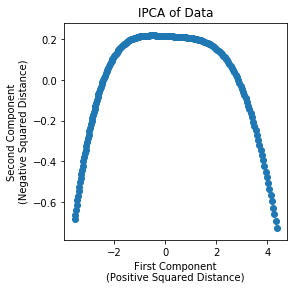

In [117]:
plt.figure(figsize=(4,4))
plt.scatter(T[:,0],T[:,1])

plt.xlabel('First Component\n(Positive Squared Distance)')
plt.ylabel('Second Component\n(Negative Squared Distance)')

plt.title('IPCA of Data')

plt.show()

C:\Users\Duncan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\Duncan\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


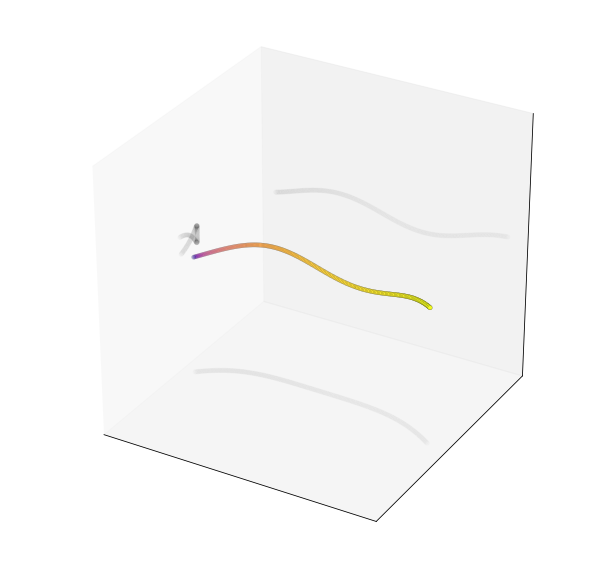

In [118]:
#3D plots
px = T[:,0]
py = T[:,1]
pz = T[:,2]
clist = [np.log10(param) for param, _ in enumerate(theta_samples)]
plot3D(px,py,pz,clist,shadow=True)   

In [119]:
T.shape

(200, 200)